In [1]:
import sys, os, copy, re, pathlib
from natsort import natsorted
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
# Delete all plots: 
if False:
    home_p = pathlib.Path('plots/')
    for path in home_p.glob('**/*.pdf'):
        # print(path)
        os.remove(path)

In [4]:
def approx_ratio_stats(a, b):
    # Making a lot of assumptions about normality
    # and no covariance estimate ratio stats:
    # https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Quantifying_Nature/Significant_Digits/Propagation_of_Error
    # I think this is derived from the first term of a Taylor expansion of the real solution.
    a_mean, a_stdev = a
    b_mean, b_stdev = b
    ratio_mean = a_mean / b_mean
    ratio_stdev = ratio_mean * np.sqrt((a_stdev / a_mean)**2 + (b_stdev / b_mean)**2)
    return((ratio_mean, ratio_stdev))

In [5]:
# Convert row letter to integer,
# for indicating replicates:
letter2rep = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

In [6]:
# Read sample annotations:
sample_anno = pd.read_excel('sample_annotations.xlsx')
sample_anno

,Cell_line,Folder,Plate,Time_first_mes,Timepoints,Gradient,Unit,Drug,Rescue,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6
0,HT1080-WT_ATF4-rep,01-04-22_high,p1,2.0,True,False,NaN,Vehicle,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
1,HT1080-WT_ATF4-rep,01-04-22_high,p2,2.0,True,False,NaN,Rotenone,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
2,HT1080-WT_ATF4-rep,01-04-22_high,p3,2.0,True,False,NaN,Antimycin,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
3,HT1080-WT_ATF4-rep,01-04-22_high,p4,2.0,True,False,NaN,Oligomycin,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
4,HT1080-WT_ATF4-rep,01-04-22_high,p5,2.0,True,False,NaN,FCCP,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,143B-WT_ATF4-rep,03-13-22_high1,p2,2.0,True,False,NaN,Rotenone,NA1,Vehicle,Suc,Fum,Mal,Ace,Asn
115,143B-WT_ATF4-rep,03-13-22_high1,p3,2.0,True,False,NaN,Antimycin,NA1,Vehicle,Suc,Fum,Mal,Ace,Asn
116,143B-WT_ATF4-rep_GCN2-KO-pool,04-09-22_high-GCN2,p1,21.0,False,False,NaN,Vehicle,NA1,Vehicle,Asn,SM,Asp,Pyr,All
117,143B-WT_ATF4-rep_GCN2-KO-pool,04-09-22_high-GCN2,p2,21.0,False,False,NaN,Rotenone,NA1,Vehicle,Asn,SM,Asp,Pyr,All


# Helper functions

Functions for reading IncuCyte data, merging with sample annotations and normalizing based of Vehicle plate. Also functions for plotting the resulting processed data.

In [7]:
def rp_data(cell_line_folder, date_list, sample_anno):
    # Read data into dataframe:
    data = pd.DataFrame(columns=['Folder', 'Plate', 'Time', 'Gradient', 'Drug', 'Rescue', 'Rescue name', 'Drug unit', 'Replicate', 'RFP', 'RFP_norm'])
    row_idx = 0
    home_p = pathlib.Path('data/{}'.format(cell_line_folder))
    for path in home_p.glob('*'):
        folder = str(path).split('/')[-1]
        # Require the date to be part of folder name:
        if sum(1 for d in date_list if d in folder) == 0:
            continue
        for fnam in natsorted(home_p.glob('{}/*.txt'.format(folder))):
            plate = str(fnam).split('/')[-1][:-4]
            tmp_df = pd.read_csv(fnam, skiprows=1, sep='\t')

            for time_idx in range(len(tmp_df)):
                elapsed = tmp_df.loc[time_idx, 'Elapsed']
                for colnam, val in zip(tmp_df.columns, tmp_df.loc[time_idx].values):
                    if colnam[0] in 'ABCD' and colnam[1] in '123456':
                        pass
                    else:
                        continue

                    rep = letter2rep[colnam[0]]
                    col = 'Col {}'.format(colnam[1])
                    mask = (sample_anno['Folder'] == folder) & (sample_anno['Plate'] == plate)
                    time = elapsed + sample_anno.loc[mask, 'Time_first_mes'].values[0]
                    gradient = sample_anno.loc[mask, 'Gradient'].values[0]
                    drug = sample_anno.loc[mask, 'Drug'].values[0]
                    rescue = sample_anno.loc[mask, col].values[0]
                    rescue_name = sample_anno.loc[mask, 'Rescue'].values[0]
                    drug_unit = sample_anno.loc[mask, 'Unit'].values[0]
                    data_list = [folder, plate, time, gradient, drug, rescue, rescue_name, drug_unit, rep, val, 0]
                    data.loc[row_idx, :] = data_list
                    row_idx += 1
    data.RFP = data.RFP.astype(float)
    data.Time = data.Time.astype(float)

    # Normalize to vehicle plate and vehicle/vehicle:
    data['RFP_vec'] = 0
    data['RFP_vec-vec'] = 0
    for folder in set(data['Folder'].values):
        for dtp in ['Mix', 'Asp', 'Mal', 'Gradient', 'Other']:
            if dtp == 'Mix':
                mask_folder_mix = (data['Folder'] == folder) & (data['Drug'] == 'Mix')
                mask_denom = (data['Folder'] == folder) & (data['Drug'] == 'Mix') & (data['Rescue'] == 'Vehicle')
                # Extract Vehicle RFP:
                df_vec = data.loc[mask_denom, ['Time', 'RFP']].groupby('Time').mean()
                # Merge based on time:
                df_b = data.loc[mask_folder_mix, ]
                df_b_merged = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                # Insert the time matched vehicle RFP into dataframe:
                data.loc[mask_folder_mix, 'RFP_vec'] = df_b_merged['RFP_vec-merged'].values
                data.loc[mask_folder_mix, 'RFP_vec-vec'] = df_b_merged['RFP_vec-merged'].values
            
            elif dtp == 'Asp':
                mask_folder_asp = (data['Folder'] == folder) & \
                                  (data['Drug'] == 'Aspartate')
#                                  ((data['Drug'] == 'Aspartate') | (data['Drug'] == 'Malate'))
                mask_denom = (data['Folder'] == folder) & \
                             (data['Rescue name'] == 'Vehicle') & \
                             (data['Drug'] == 'Aspartate')
#                             ((data['Drug'] == 'Aspartate') | (data['Drug'] == 'Malate')) & \

                if sum(mask_folder_asp) == 0 or sum(mask_denom) == 0:
                    continue
                max_asp = max(data[mask_denom]['Rescue'])
                mask_denom &= (data['Rescue'] == max_asp)
                # Extract Vehicle RFP:
                df_vec = data.loc[mask_denom, ['Time', 'RFP']].groupby('Time').mean()
                # Merge based on time:
                df_b = data.loc[mask_folder_asp, ]
                df_b_merged = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                # Insert the time matched vehicle RFP into dataframe:
                data.loc[mask_folder_asp, 'RFP_vec'] = df_b_merged['RFP_vec-merged'].values
                data.loc[mask_folder_asp, 'RFP_vec-vec'] = df_b_merged['RFP_vec-merged'].values

            elif dtp == 'Mal':
                mask_folder_mal = (data['Folder'] == folder) & \
                                  (data['Drug'] == 'Malate')
                mask_denom = (data['Folder'] == folder) & \
                             (data['Rescue name'] == 'Vehicle') & \
                             (data['Drug'] == 'Malate')

                if sum(mask_folder_mal) == 0 or sum(mask_denom) == 0:
                    continue
                min_mal = min(data[mask_denom]['Rescue'])
                mask_denom &= (data['Rescue'] == min_mal)
                # Extract Vehicle RFP:
                df_vec = data.loc[mask_denom, ['Time', 'RFP']].groupby('Time').mean()
                # Merge based on time:
                df_b = data.loc[mask_folder_mal, ]
                df_b_merged = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                # Insert the time matched vehicle RFP into dataframe:
                data.loc[mask_folder_mal, 'RFP_vec'] = df_b_merged['RFP_vec-merged'].values
                data.loc[mask_folder_mal, 'RFP_vec-vec'] = df_b_merged['RFP_vec-merged'].values

            elif dtp == 'Gradient':
                mask_folder_grad = (data['Folder'] == folder) & (data['Gradient']) & \
                                   ((data['Drug'] != 'Aspartate') & (data['Drug'] != 'Malate'))
                g_drug_list = list(set(data[mask_folder_grad]['Drug']))
                for g_drug in g_drug_list:
                    mask_folder_grad_drug = mask_folder_grad & (data['Drug'] == g_drug)
                    mask_denom = (data['Folder'] == folder) & (data['Gradient']) & \
                                 (data['Drug'] == g_drug)
                    if sum(mask_folder_grad_drug) == 0 or sum(mask_denom) == 0:
                        continue
                    min_drug = min(data[mask_denom]['Rescue'])
                    mask_denom &= (data['Rescue'] == min_drug)
                    # Extract Vehicle RFP:
                    df_vec = data.loc[mask_denom, ['Time', 'RFP']].groupby('Time').mean()
                    # Merge based on time:
                    df_b = data.loc[mask_folder_grad_drug, ]
                    df_b_merged = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                    # Insert the time matched vehicle RFP into dataframe:
                    data.loc[mask_folder_grad_drug, 'RFP_vec'] = df_b_merged['RFP_vec-merged'].values
                    data.loc[mask_folder_grad_drug, 'RFP_vec-vec'] = df_b_merged['RFP_vec-merged'].values
            

            
            else:
                mask_folder_mix = (data['Folder'] == folder) & \
                                  (data['Drug'] != 'Mix') & \
                                  ((data['Drug'] != 'Aspartate') & (data['Drug'] != 'Malate')) & \
                                  (~data['Gradient'])
                mask_denom_vec = (data['Folder'] == folder) & (data['Drug'] == 'Vehicle')
                mask_denom_vec_vec = (data['Folder'] == folder) & (data['Drug'] == 'Vehicle') & (data['Rescue'] == 'Vehicle')
                # Extract Vehicle RFP:
                df_vec = data.loc[mask_denom_vec, ['Time', 'RFP']].groupby('Time').mean()
                df_vec_vec = data.loc[mask_denom_vec_vec, ['Time', 'RFP']].groupby('Time').mean()
                # Merge based on time:
                df_b = data.loc[mask_folder_mix, ]
                df_b_merged_vec = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                df_b_merged_vec_vec = df_b.merge(df_vec_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                # Insert the time matched vehicle RFP into dataframe:
                data.loc[mask_folder_mix, 'RFP_vec'] = df_b_merged_vec['RFP_vec-merged'].values
                data.loc[mask_folder_mix, 'RFP_vec-vec'] = df_b_merged_vec_vec['RFP_vec-merged'].values

    # Normalize based on the average accross the whole vehicle plate:
    data['RFP_norm-VecPlate'] = data['RFP'] / data['RFP_vec']
    # Normalize based on the Vehicle column on the vehicle plate:
    data['RFP_norm-Vec-Vec'] = data['RFP'] / data['RFP_vec-vec']
    
    return(data)

In [8]:
def plot_timecourse(data, folder, drug_list, red, plot_dst, norm,
                    resc_excl=['NA1', 'NA2', 'SM'], fig_size_w=None):
    for drug in drug_list:
        if fig_size_w is not None:
            fig, ax1 = plt.subplots(1, 1, figsize=(fig_size_w, 5))
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        mask = (data['Folder'] == folder) & (data['Drug'] == drug)
        for rscl in resc_excl:
            mask &= (data['Rescue'] != rscl)

        if drug != 'Mix':
            try:
                hue_list = ['Vehicle', 'Asn', 'SM', 'Asp', 'Pyr', 'aKB', 'All']
                hue_obs = list(set(data[mask]['Rescue'].values))
                hue_order = sorted(hue_obs, key=lambda x: hue_list.index(x))
                hue2col = {hue: palette[i] for i, hue in enumerate(hue_list)}
            except:
                hue_list = ['Vehicle', 'Asn', 'Suc', 'Fum', 'Mal', 'Ace']
                hue_obs = list(set(data[mask]['Rescue'].values))
                hue_order = sorted(hue_obs, key=lambda x: hue_list.index(x))
                hue2col = {hue: palette[i] for i, hue in enumerate(hue_list)}
            g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y=norm, hue='Rescue', hue_order=hue_order, palette=hue2col, errorbar=('ci', 90), markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
            ax1.axvline(x=red['NoMix'], color='r', linestyle='--', zorder=0)
        else:
            g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y=norm, hue='Rescue', errorbar=('ci', 90), markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
            ax1.axvline(x=red['Mix'], color='r', linestyle='--', zorder=0)
        ax1.set_xlim(0, ax1.get_xlim()[1])
        if norm != 'RFP':
            ax1.set_ylim(0, ax1.get_ylim()[1])
        if norm == 'RFP':
            g1.set_ylabel('RFP (AU)')
        elif 'VecPlate' in norm:
            g1.set_ylabel('RFP (norm. to Vec. plate)')
        else:
            g1.set_ylabel('RFP (norm. to Vec/Vec)')
        g1.set_xlabel('Time after treatment (hours)')
        g1.set_title('{}'.format(drug))
        g1.grid(True, axis='y')
        g1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='Rescue')
        sns.despine()
        fig.tight_layout()
        if norm == 'RFP':
            fig.savefig('{}/{}_{}-timecourse.pdf'.format(plot_dst, folder, drug), bbox_inches='tight')
        else:
            fig.savefig('{}/{}_{}-timecourse_norm.pdf'.format(plot_dst, folder, drug), bbox_inches='tight')

In [9]:
def plot_timecourse_gradient(data, folder, drug_list, rescue_list, red, plot_dst, norm,
                             resc_excl=['NA1', 'NA2', 'SM'], fig_size_w=None):
    for drug in drug_list:
        for resc_nam in rescue_list:
            if fig_size_w is not None:
                fig, ax1 = plt.subplots(1, 1, figsize=(fig_size_w, 5))
            else:
                fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
            mask = (data['Folder'] == folder) & (data['Drug'] == drug) & (data['Rescue name'] == resc_nam)
            for rscl in resc_excl:
                mask &= (data['Rescue'] != rscl)

            hue_order = sorted(list(set(data[mask]['Rescue'].values)))
            hue2col = {hue: palette[i] for i, hue in enumerate(hue_order)}
            g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y=norm, hue='Rescue', hue_order=hue_order, palette=hue2col, errorbar=('ci', 90), markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
            ax1.axvline(x=red['NoMix'], color='r', linestyle='--', zorder=0)
            ax1.set_xlim(0, ax1.get_xlim()[1])
            if norm != 'RFP':
                ax1.set_ylim(0, ax1.get_ylim()[1])
            if norm == 'RFP':
                g1.set_ylabel('RFP (AU)')
            elif 'VecPlate' in norm:
                g1.set_ylabel('RFP (norm. to Vec. plate)')
            else:
                g1.set_ylabel('RFP (norm. to Vec/Vec)')
            g1.set_xlabel('Time after treatment (hours)')
            if resc_nam != 'NA1':
                g1.set_title('{}'.format(resc_nam))
            else:
                g1.set_title('')
            g1.grid(True, axis='y')
            drug_unit = data[mask]['Drug unit'].values[0]
            g1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='{} ({})'.format(drug, drug_unit))
            sns.despine()
            fig.tight_layout()
            if norm == 'RFP':
                fig.savefig('{}/{}_{}_{}-timecourse.pdf'.format(plot_dst, folder, drug, resc_nam), bbox_inches='tight')
            else:
                fig.savefig('{}/{}_{}_{}-timecourse_norm.pdf'.format(plot_dst, folder, drug, resc_nam), bbox_inches='tight')

In [10]:
def plot_bars(data, folder, time, norm, title, ext='', y0=None, y1=None,
              resc_excl=['NA1', 'NA2', 'SM'], drug_excl=[], drug_incl=None, fig_size_w=None):
    mask = (data['Folder'] == folder) & (data['Drug'] != 'Mix') & \
           (data['Time'] == time) & (~data['Gradient'])
    for rscl in resc_excl:
        mask &= (data['Rescue'] != rscl)
    for drcl in drug_excl:
        mask &= (data['Drug'] != drcl)
    if drug_incl is not None:
        mask &= data['Drug'].isin(drug_incl)
    dmult = len(set(data[mask]['Drug'])) / 5.0
    if fig_size_w is not None:
        fig, ax1 = plt.subplots(1, 1, figsize=(fig_size_w, 5))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(11*dmult, 5))
    try:
        hue_list = ['Vehicle', 'Asn', 'SM', 'Asp', 'Pyr', 'aKB', 'All']
        hue_obs = list(set(data[mask]['Rescue'].values))
        hue_order = sorted(hue_obs, key=lambda x: hue_list.index(x))
        hue2col = {hue: palette[i] for i, hue in enumerate(hue_list)}
    except:
        hue_list = ['Vehicle', 'Asn', 'Suc', 'Fum', 'Mal', 'Ace']
        hue_obs = list(set(data[mask]['Rescue'].values))
        hue_order = sorted(hue_obs, key=lambda x: hue_list.index(x))
        hue2col = {hue: palette[i] for i, hue in enumerate(hue_list)}
    g1 = sns.barplot(ax=ax1, data=data[mask], x='Drug', y=norm, hue='Rescue', hue_order=hue_order, palette=hue2col, errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    if not 1 in plt.yticks()[0]:
        ax1.axhline(y=1, color='r', linestyle='--', zorder=0)
    if norm != 'RFP' and y0 is None:
        ax1.set_ylim(0, ax1.get_ylim()[1])
    elif y0 is not None and y1 is None:
        ax1.set_ylim(y0, ax1.get_ylim()[1])
    elif y0 is not None and y1 is not None:
        ax1.set_ylim(y0, y1)
    if norm == 'RFP':
        g1.set_ylabel('RFP (AU)')
    elif 'VecPlate' in norm:
        g1.set_ylabel('RFP (norm. to Vec. plate)')
    else:
        g1.set_ylabel('RFP (norm. to Vec/Vec)')
    g1.set_xlabel('')
    g1.set_title(title)
    g1.grid(True, axis='y')
    g1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='Rescue')
    #g1.set(yscale="log")
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}-mito-inhib_barplot{}.pdf'.format(plot_dst, folder, ext), bbox_inches='tight')

In [11]:
def plot_bars_gradient(data, folder, drug_list, time, norm, title, ext='', y0=None, y1=None,
                       resc_excl=['NA1', 'NA2', 'SM'], drug_excl=[],
                       fig_size_w=None, show_xticks=True):
    
    for drug in drug_list:
        mask = (data['Folder'] == folder) & (data['Drug'] != 'Mix') & \
               (data['Time'] == time) & (data['Drug'] == drug) & (data['Gradient'])
        for rscl in resc_excl:
            mask &= (data['Rescue name'] != rscl)
        for drcl in drug_excl:
            mask &= (data['Drug'] != drcl)
        dmult = len(set(data[mask]['Rescue name'])) / 5.0
        if fig_size_w is not None:
            fig, ax1 = plt.subplots(1, 1, figsize=(fig_size_w, 5))
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(11*dmult, 5))

        hue_order = sorted(list(set(data[mask]['Rescue'].values)))
        hue2col = {hue: palette[i] for i, hue in enumerate(hue_order)}
        g1 = sns.barplot(ax=ax1, data=data[mask], x='Rescue name', y=norm, hue='Rescue', hue_order=hue_order, palette=hue2col, errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
        
        if not 1 in plt.yticks()[0]:
            ax1.axhline(y=1, color='r', linestyle='--', zorder=0)
        if norm != 'RFP' and y0 is None:
            ax1.set_ylim(0, ax1.get_ylim()[1])
        elif y0 is not None and y1 is None:
            ax1.set_ylim(y0, ax1.get_ylim()[1])
        elif y0 is not None and y1 is not None:
            ax1.set_ylim(y0, y1)
        if norm == 'RFP':
            g1.set_ylabel('RFP (AU)')
        elif 'VecPlate' in norm:
            g1.set_ylabel('RFP (norm. to Vec. plate)')
        else:
            g1.set_ylabel('RFP (norm. to Vec/Vec)')
        
        if not show_xticks:
            plt.xticks([])        
        g1.set_xlabel('')
        g1.set_title(title)
        g1.grid(True, axis='y')
        drug_unit = data[mask]['Drug unit'].values[0]
        g1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, \
                  title='{} ({})'.format(drug, drug_unit))
        #g1.set(yscale="log")
        sns.despine()
        fig.tight_layout()
        fig.savefig('{}/{}_{}_barplot{}.pdf'.format(plot_dst, drug, folder, ext), bbox_inches='tight')

In [12]:
def plot_bar_Atp(data, fd, td, norm, plot_dst, title):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
    mask = (data['Drug'] == 'Mix') & (((data['Folder'] == fd['low']) & (data['Time'] == td['low'])) | ((data['Folder'] == fd['high']) & (data['Time'] == td['high'])))
    order = [fd['low'], fd['high']]
    g1 = sns.barplot(ax=ax1, data=data[mask], x='Folder', y='RFP_norm-Vec-Vec', order=order, hue='Rescue', errorbar=('ci', 95), capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('Clone')
    if not 1 in plt.yticks()[0]:
        ax1.axhline(y=1, color='r', linestyle='--', zorder=0)
    if norm != 'RFP':
        ax1.set_ylim(0, ax1.get_ylim()[1])
    if norm == 'RFP':
        g1.set_ylabel('RFP (AU)')
    elif 'VecPlate' in norm:
        g1.set_ylabel('RFP (norm. to Vec. plate)')
    else:
        g1.set_ylabel('RFP (norm. to Vehicle)')
    g1.set_title(title)
    g1.grid(True, axis='y')
    g1.set_xticklabels(['Low', 'High'])
    g1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='Drug')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/low_high_Atpenin.pdf'.format(plot_dst), bbox_inches='tight')

# Process HT1080 data from 01-04-22 and 01-05-22

In [14]:
### Process HT1080 data from 01-04-22 and 01-05-22 ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
# date_list = ['01-04-22', '01-05-22']
date_list = ['01-04-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080/01-0X-22'

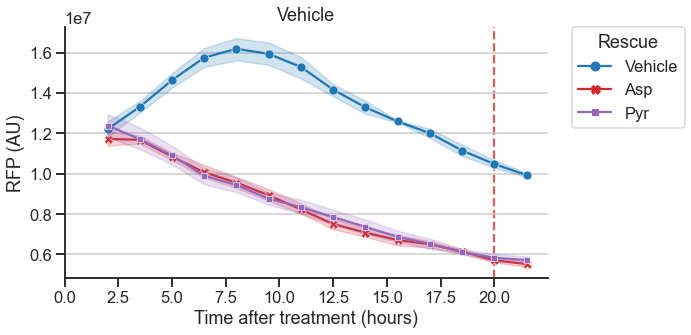

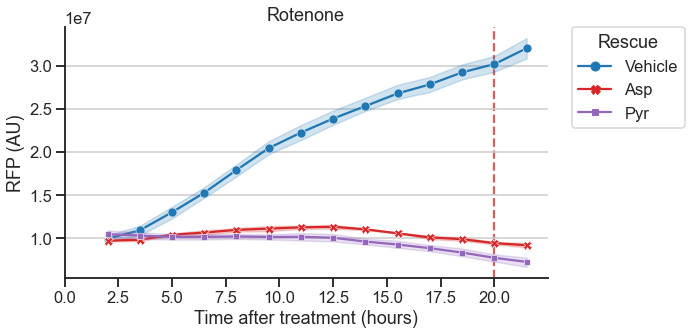

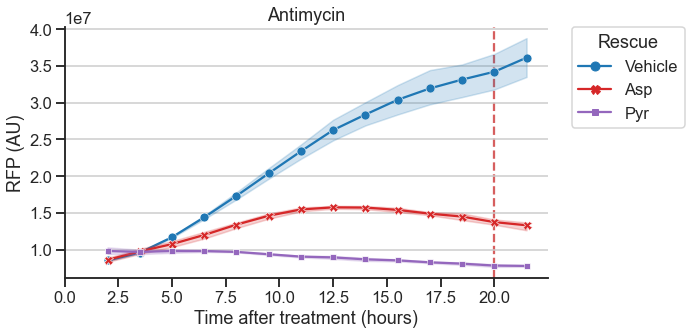

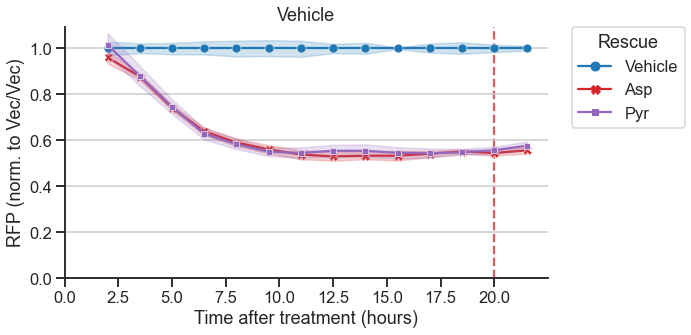

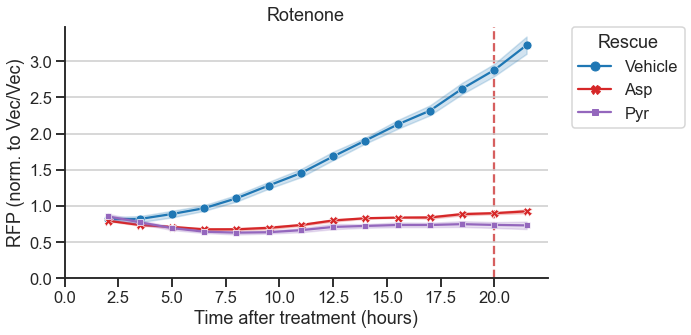

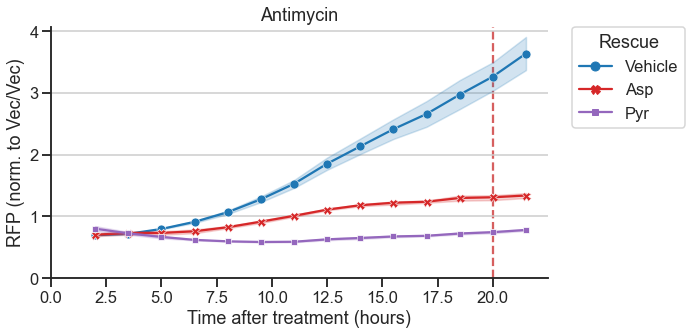

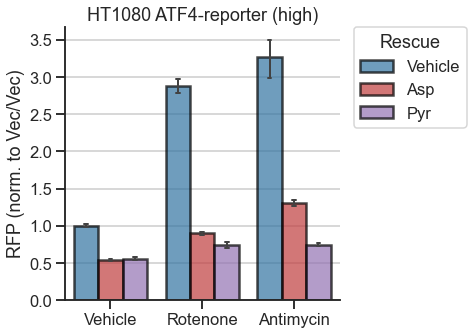

In [15]:
### Plot RFP timecourse - 01-04-22 ###
folder = '01-04-22_high'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin']
drug_excl = ['Oligomycin', 'BAM15', 'FCCP']
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl, fig_size_w=7)

In [16]:
# Skip, no Vehicle for the skip in sample (01-07-22)
'''
### Plot RFP timecourse - 01-05-22 ###
folder = '01-05-22_low'
red = {'NoMix': 17.5, 'Mix': 17.5}
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl, fig_size_w=7)
'''

"\n### Plot RFP timecourse - 01-05-22 ###\nfolder = '01-05-22_low'\nred = {'NoMix': 17.5, 'Mix': 17.5}\nnorm = 'RFP_norm-Vec-Vec'\nplot_timecourse(data, folder, drug_list, red, plot_dst, norm)\ntitle = 'HT1080 ATF4-reporter (low)'\nplot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl, fig_size_w=7)\n"

# Process HT1080 data from 01-06-22 and 01-07-22

In [17]:
### Process HT1080 data from 01-06-22 and 01-07-22 ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
# date_list = ['01-06-22', '01-07-22']
date_list = ['01-06-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080/01-0Xv2-22'

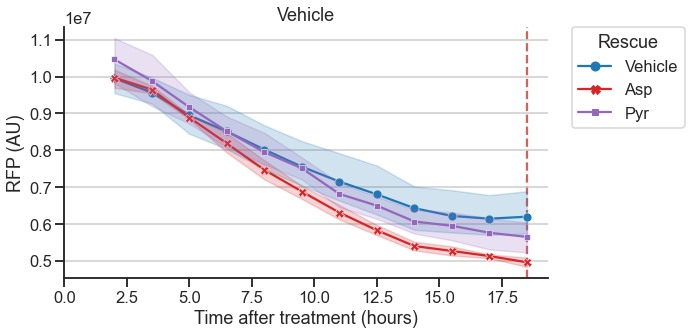

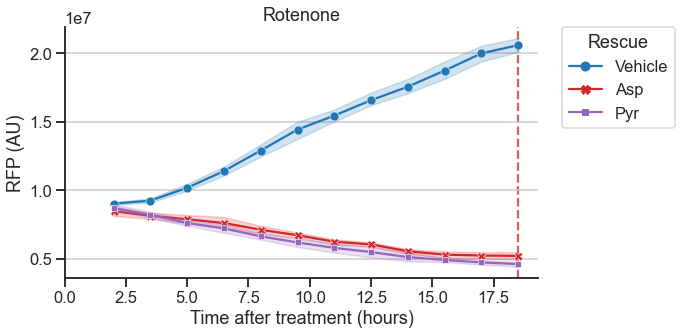

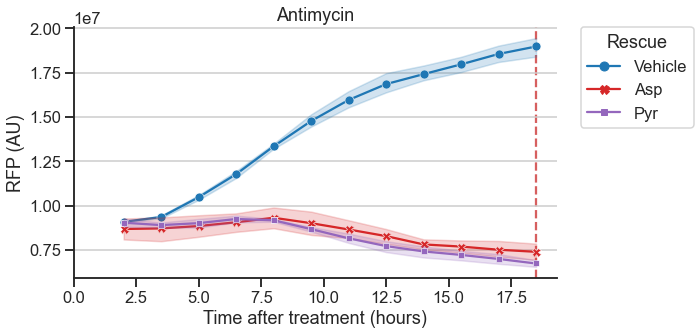

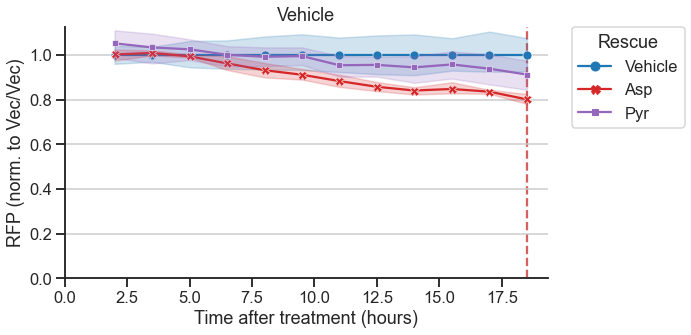

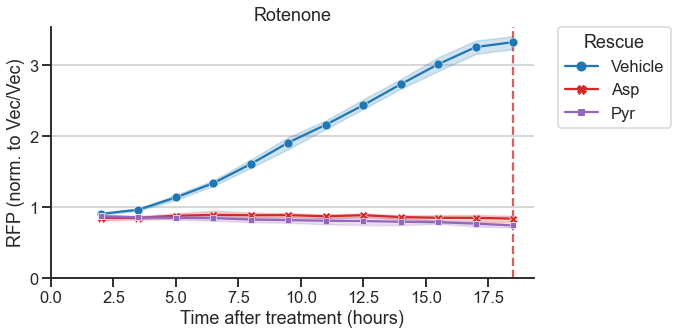

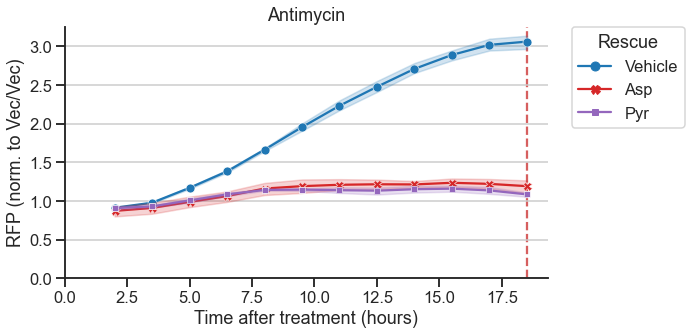

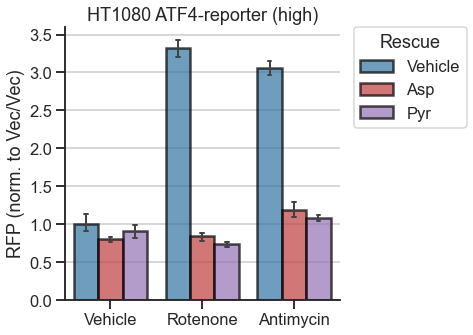

In [18]:
### Plot RFP timecourse - 01-06-22 ###
folder = '01-06-22_high'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin']
drug_excl = ['Oligomycin', 'BAM15', 'FCCP']
red = {'NoMix': 18.5, 'Mix': 18.5}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title, '_norm', drug_excl=drug_excl, fig_size_w=7)

In [19]:
# Skip, no Vehicle
'''
### Plot RFP timecourse - 01-07-22 ###
# Don't have Vehicle plate for this batch #
folder = '01-07-22_low'
drug_list = ['Rotenone', 'Antimycin']
drug_excl = ['Oligomycin', 'FCCP', 'BAM15']
red = {'NoMix': 18.5, 'Mix': 18.5}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (low)'
#plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl, fig_size_w=7)
'''

"\n### Plot RFP timecourse - 01-07-22 ###\n# Don't have Vehicle plate for this batch #\nfolder = '01-07-22_low'\ndrug_list = ['Rotenone', 'Antimycin']\ndrug_excl = ['Oligomycin', 'FCCP', 'BAM15']\nred = {'NoMix': 18.5, 'Mix': 18.5}\nnorm = 'RFP'\nplot_timecourse(data, folder, drug_list, red, plot_dst, norm)\ntitle = 'HT1080 ATF4-reporter (low)'\n#plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl, fig_size_w=7)\n"

# Process HT1080 data from 01-10-22 and 01-11-22

In [20]:
### Process HT1080 data from 01-10-22 and 01-11-22 ###
# These plates only have a single endpoint read #
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['01-10-22', '01-11-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080/01-1X-22'

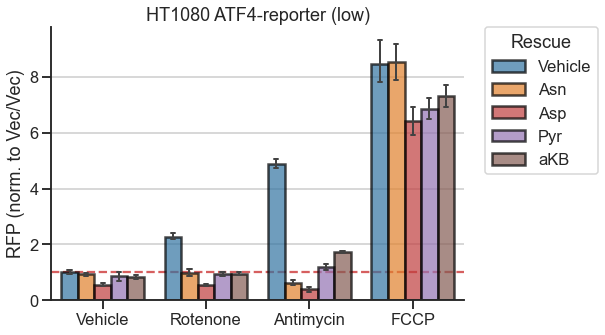

In [21]:
### Plot mito inhibitors for HT1080 ATF4-rep (low) ###
folder = '01-11-22_low'
drug_excl = ['Oligomycin']
red = {'NoMix': 17, 'Mix': 17}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

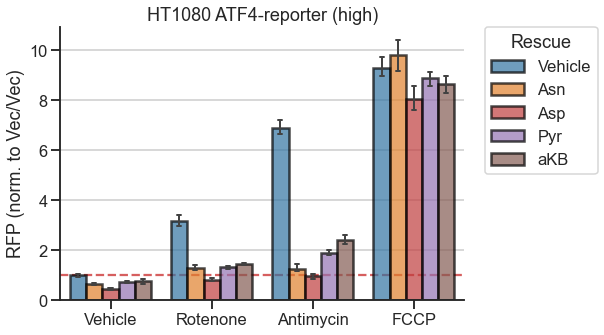

In [22]:
### Plot mito inhibitors for HT1080 ATF4-rep (high) ###
folder = '01-10-22_high'
red = {'NoMix': 17, 'Mix': 17}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

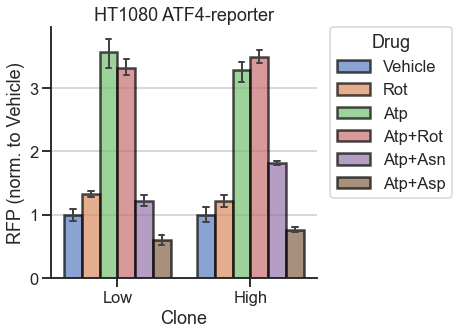

In [23]:
### Plot Atpenin data - 01-2X-22 ###
fd = {'low': '01-11-22_low', 'high': '01-10-22_high'}
td = {'low': 17, 'high': 17}
title = 'HT1080 ATF4-reporter'
plot_bar_Atp(data, fd, td, norm, plot_dst, title)

# Process HT1080 data from 01-13-22

In [24]:
# These cells were used for flow #
'''
### Process HT1080 data from 01-13-22 ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['01-13-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080/01-1X-22'

### Plot RFP timecourse - 01-13-22 ###
folder = '01-13-22_low'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'Mix']
red = {'NoMix': 18, 'Mix': 18}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title)
'''

"\n### Process HT1080 data from 01-13-22 ###\ncell_line_folder = 'HT1080-WT_ATF4-rep'\ndate_list = ['01-13-22']\ndata = rp_data(cell_line_folder, date_list, sample_anno)\nplot_dst = 'plots/HT1080/01-1X-22'\n\n### Plot RFP timecourse - 01-13-22 ###\nfolder = '01-13-22_low'\ndrug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'Mix']\nred = {'NoMix': 18, 'Mix': 18}\nnorm = 'RFP'\nplot_timecourse(data, folder, drug_list, red, plot_dst, norm)\nnorm = 'RFP_norm-Vec-Vec'\nplot_timecourse(data, folder, drug_list, red, plot_dst, norm)\ntitle = 'HT1080 ATF4-reporter (low)'\nplot_bars(data, folder, red['NoMix'], norm, title)\n"

# Process 143B data from 01-24-22 and 01-26-22

In [25]:
### Process 143B data from 01-24-22 and 01-26-22 ###
cell_line_folder = '143B-WT_ATF4-rep'
date_list = ['01-24-22', '01-26-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/143B/01-2X-22'

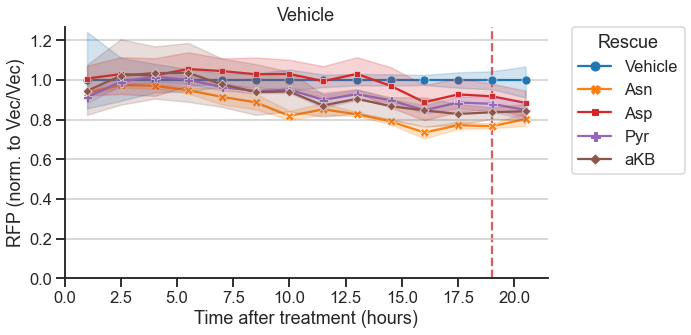

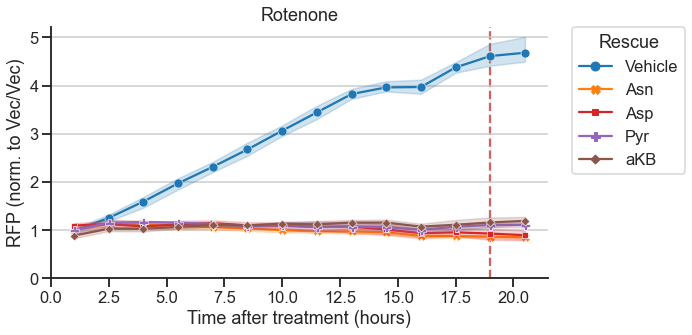

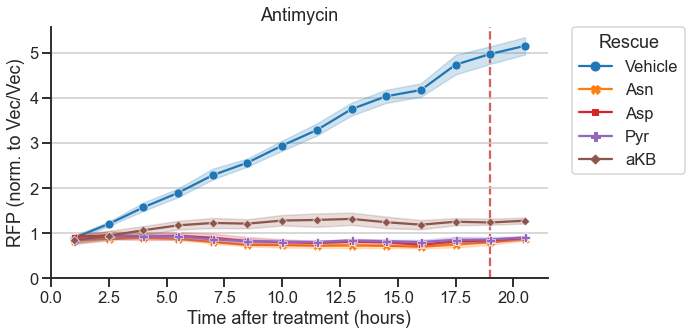

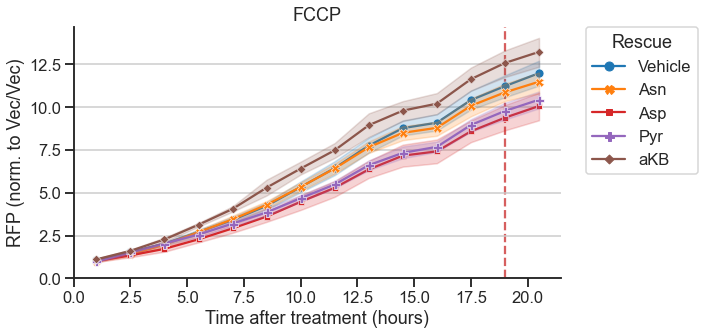

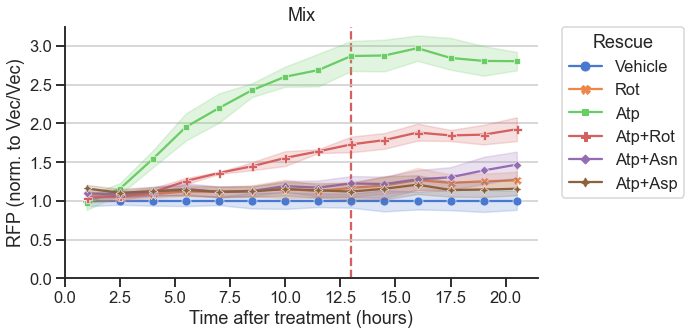

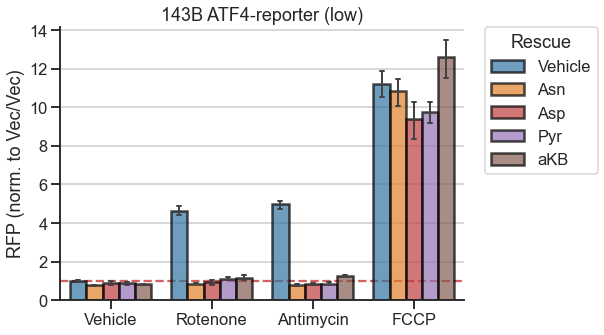

In [26]:
### Plot RFP timecourse - 01-24-22 ###
folder = '01-24-22_low'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'FCCP', 'Mix']
drug_excl = ['Oligomycin']
red = {'NoMix': 19, 'Mix': 13}
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = '143B ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

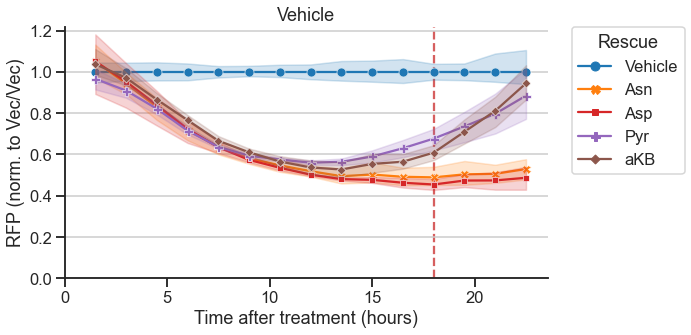

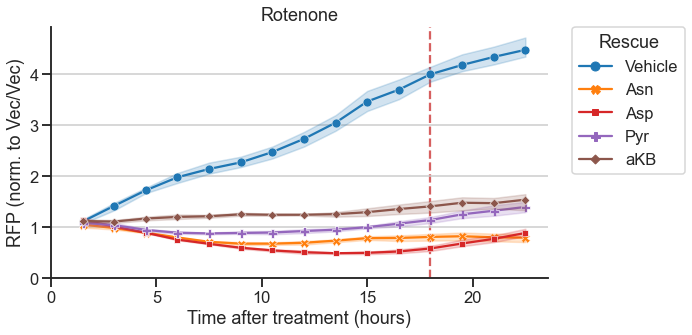

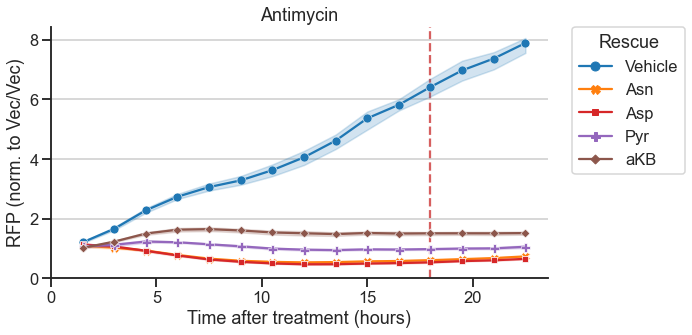

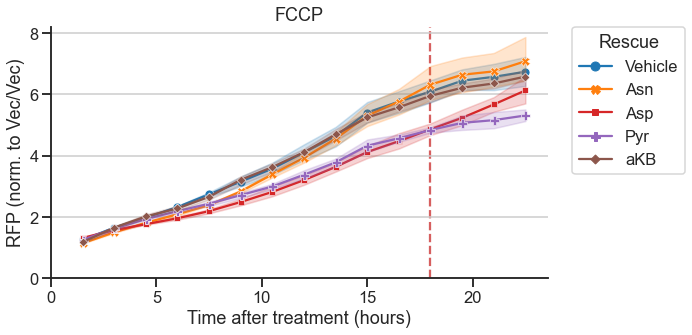

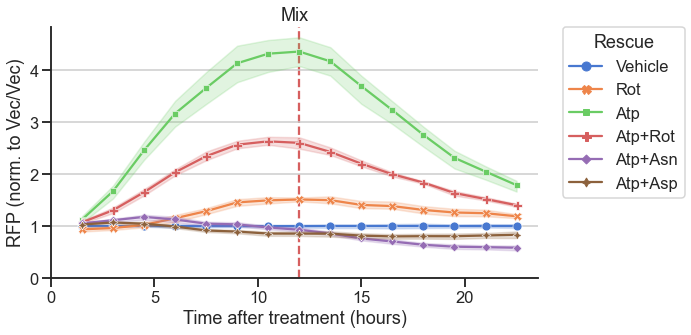

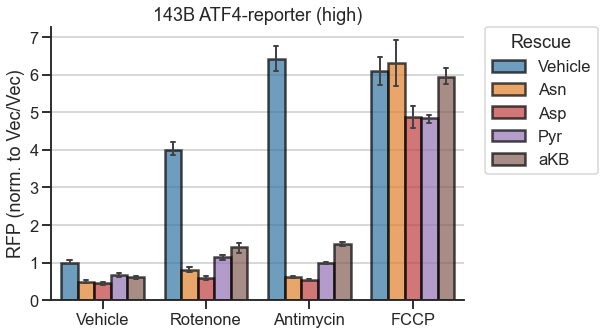

In [27]:
### Plot RFP timecourse - 01-26-22 ###
folder = '01-26-22_high'
red = {'NoMix': 18, 'Mix': 12}
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = '143B ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

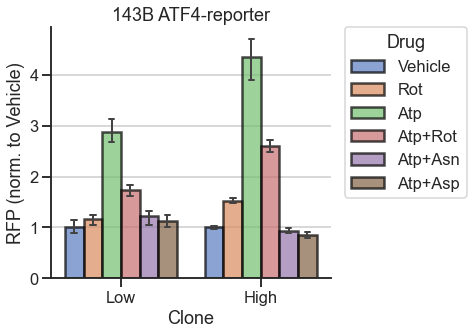

In [28]:
### Plot Atpenin data - 01-2X-22 ###
fd = {'low': '01-24-22_low', 'high': '01-26-22_high'}
td = {'low': 13, 'high': 12}
title = '143B ATF4-reporter'
plot_bar_Atp(data, fd, td, norm, plot_dst, title)

# Process HT1080 HRI KO pool data from 02-04-22

In [29]:
### Process data ###
cell_line_folder = 'HT1080-WT_ATF4-rep_HRI-KO-pool'
date_list = ['02-04-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080-pooled-KO/02-04-22_HRI'

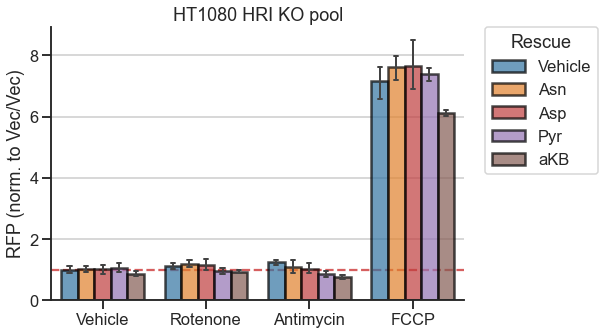

In [30]:
### Plot RFP timecourse ###
folder = '02-04-22_low-HRI'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'FCCP', 'Mix']
drug_excl = ['Oligomycin']
red = {'NoMix': 22.5, 'Mix': 22.5}
norm = 'RFP_norm-Vec-Vec'
# plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 HRI KO pool'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

# Process HT1080 OMA1 KO pool data from 02-04-22

In [14]:
### Process data ###
cell_line_folder = 'HT1080-WT_ATF4-rep_OMA1-KO-pool'
date_list = ['02-04-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080-pooled-KO/02-04-22_OMA1'

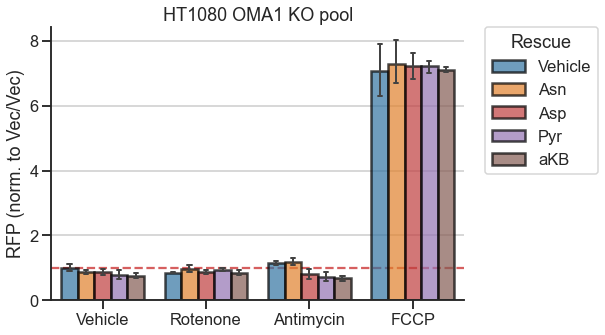

In [15]:
### Plot RFP timecourse ###
folder = '02-04-22_low-OMA1'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'FCCP', 'Mix']
drug_excl = ['Oligomycin']
red = {'NoMix': 21, 'Mix': 21}
norm = 'RFP_norm-Vec-Vec'
# plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 OMA1 KO pool'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

# Process 143B GCN2 KO pool data from 04-09-22

In [17]:
### Process data ###
cell_line_folder = '143B-WT_ATF4-rep_GCN2-KO-pool'
date_list = ['04-09-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/143B-pooled-KO/04-09-22_GCN2'

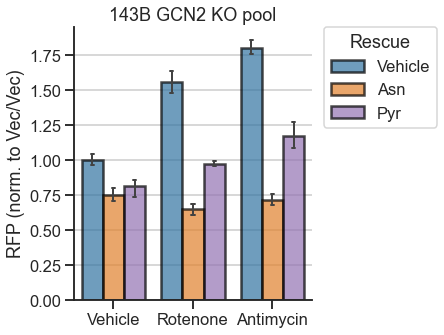

In [21]:
### Plot RFP timecourse ###
folder = '04-09-22_high-GCN2'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin']
red = {'NoMix': 21, 'Mix': 21}
norm = 'RFP_norm-Vec-Vec'
title = '143B GCN2 KO pool'
plot_bars(data, folder, red['NoMix'], norm, title, resc_excl=['SM', 'Asp', 'All'])

In [16]:
sample_anno

,Cell_line,Folder,Plate,Time_first_mes,Timepoints,Gradient,Unit,Drug,Rescue,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6
0,HT1080-WT_ATF4-rep,01-04-22_high,p1,2.0,True,False,NaN,Vehicle,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
1,HT1080-WT_ATF4-rep,01-04-22_high,p2,2.0,True,False,NaN,Rotenone,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
2,HT1080-WT_ATF4-rep,01-04-22_high,p3,2.0,True,False,NaN,Antimycin,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
3,HT1080-WT_ATF4-rep,01-04-22_high,p4,2.0,True,False,NaN,Oligomycin,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
4,HT1080-WT_ATF4-rep,01-04-22_high,p5,2.0,True,False,NaN,FCCP,NA1,Vehicle,SM,Asp,Pyr,NA1,NA2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,143B-WT_ATF4-rep,03-13-22_high1,p2,2.0,True,False,NaN,Rotenone,NA1,Vehicle,Suc,Fum,Mal,Ace,Asn
115,143B-WT_ATF4-rep,03-13-22_high1,p3,2.0,True,False,NaN,Antimycin,NA1,Vehicle,Suc,Fum,Mal,Ace,Asn
116,143B-WT_ATF4-rep_GCN2-KO-pool,04-09-22_high-GCN2,p1,21.0,False,False,NaN,Vehicle,NA1,Vehicle,Asn,SM,Asp,Pyr,All
117,143B-WT_ATF4-rep_GCN2-KO-pool,04-09-22_high-GCN2,p2,21.0,False,False,NaN,Rotenone,NA1,Vehicle,Asn,SM,Asp,Pyr,All


# Process HT1080 eGFP data from 02-15-22

In [33]:
# Cells were fixed, thus pretty crappy #
'''
### Process data ###
# These plates only have a single endpoint read #
# Cells were fixed and data quality here is suboptimal #
cell_line_folder = 'HT1080-WT_ATF4-rep_eGFP'
date_list = ['02-15-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080-eGFP-ASNS/02-15-22_eGFP'

### Plot mito inhibitors for HT1080 ATF4-rep (low) ###
folder = '02-15-22_low-eGFP-mean'
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-rep eGFP OE'
plot_bars(data, folder, red['NoMix'], norm, title, y0=0.90, y1=1.3)
'''

"\n### Process data ###\n# These plates only have a single endpoint read #\n# Cells were fixed and data quality here is suboptimal #\ncell_line_folder = 'HT1080-WT_ATF4-rep_eGFP'\ndate_list = ['02-15-22']\ndata = rp_data(cell_line_folder, date_list, sample_anno)\nplot_dst = 'plots/HT1080-eGFP-ASNS/02-15-22_eGFP'\n\n### Plot mito inhibitors for HT1080 ATF4-rep (low) ###\nfolder = '02-15-22_low-eGFP-mean'\nred = {'NoMix': 20, 'Mix': 20}\nnorm = 'RFP_norm-Vec-Vec'\ntitle = 'HT1080 ATF4-rep eGFP OE'\nplot_bars(data, folder, red['NoMix'], norm, title, y0=0.90, y1=1.3)\n"

# Process HT1080 ASNS data from 02-15-22

In [34]:
# Cells were fixed, thus pretty crappy #
'''
### Process data ###
# These plates only have a single endpoint read #
# Cells were fixed and data quality here is suboptimal #
cell_line_folder = 'HT1080-WT_ATF4-rep_ASNS'
date_list = ['02-15-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080-eGFP-ASNS/02-15-22_ASNS'

### Plot mito inhibitors for HT1080 ATF4-rep (low) ###
folder = '02-15-22_low-ASNS-mean'
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-rep ASNS OE'
plot_bars(data, folder, red['NoMix'], norm, title, y0=0.90, y1=1.3)
'''

"\n### Process data ###\n# These plates only have a single endpoint read #\n# Cells were fixed and data quality here is suboptimal #\ncell_line_folder = 'HT1080-WT_ATF4-rep_ASNS'\ndate_list = ['02-15-22']\ndata = rp_data(cell_line_folder, date_list, sample_anno)\nplot_dst = 'plots/HT1080-eGFP-ASNS/02-15-22_ASNS'\n\n### Plot mito inhibitors for HT1080 ATF4-rep (low) ###\nfolder = '02-15-22_low-ASNS-mean'\nred = {'NoMix': 20, 'Mix': 20}\nnorm = 'RFP_norm-Vec-Vec'\ntitle = 'HT1080 ATF4-rep ASNS OE'\nplot_bars(data, folder, red['NoMix'], norm, title, y0=0.90, y1=1.3)\n"

# Process HT1080 eGFP data from 02-22-22

In [35]:
### Process data ###
# These plates only have a single endpoint read #
cell_line_folder = 'HT1080-WT_ATF4-rep_eGFP'
date_list = ['02-22-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080-eGFP-ASNS/02-22-22_eGFP'

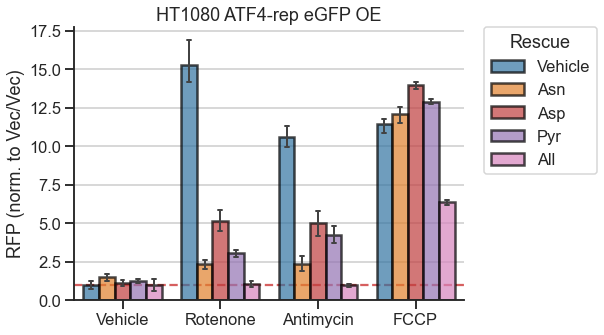

In [36]:
### Plot ###
folder = '02-22-22_low-eGFP'
drug_excl = ['Oligomycin']
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-rep eGFP OE'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

# Process HT1080 ASNS data from 02-22-22

In [37]:
### Process data ###
# These plates only have a single endpoint read #
cell_line_folder = 'HT1080-WT_ATF4-rep_ASNS'
date_list = ['02-22-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080-eGFP-ASNS/02-22-22_ASNS'

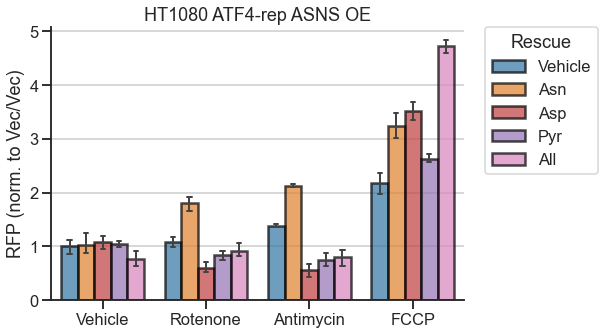

In [38]:
### Plot ###
folder = '02-22-22_low-ASNS'
drug_excl = ['Oligomycin']
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-rep ASNS OE'
plot_bars(data, folder, red['NoMix'], norm, title, drug_excl=drug_excl)

# Process HT1080 GOT DKO data from 02-01-22

In [39]:
### Process data ###
cell_line_folder = 'HT1080-GOT-DKO_ATF4-rep'
date_list = ['02-01-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080-GOT-DKO/02-01-22'

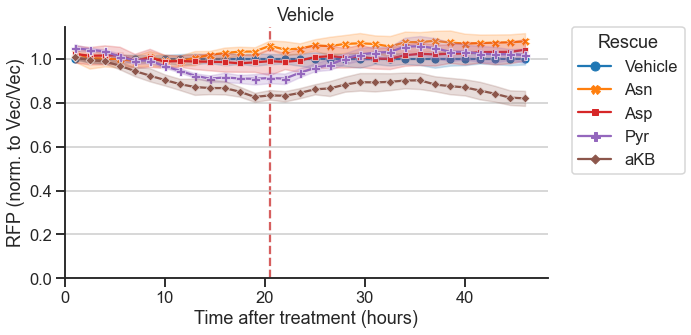

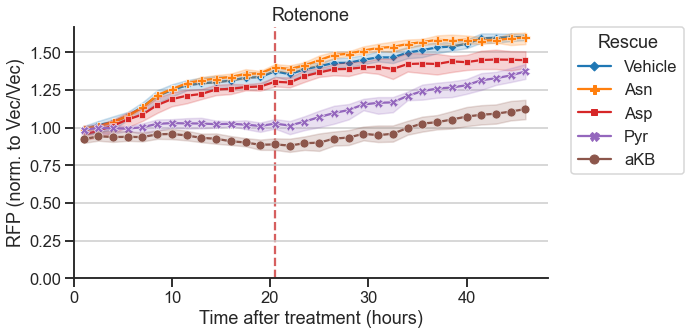

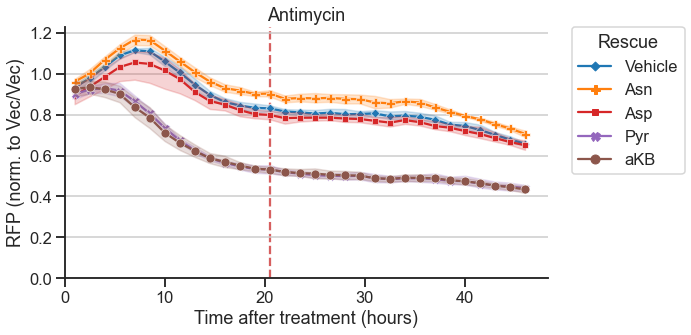

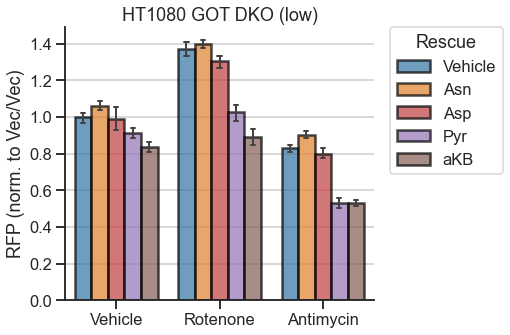

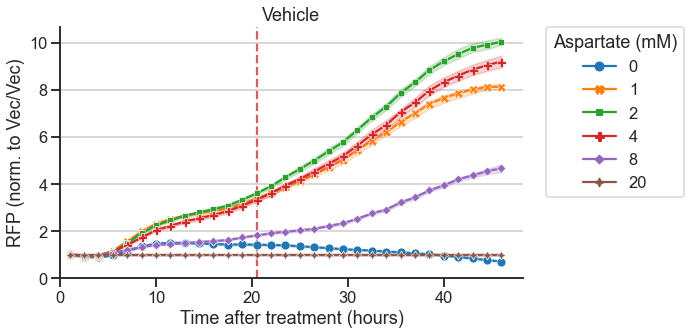

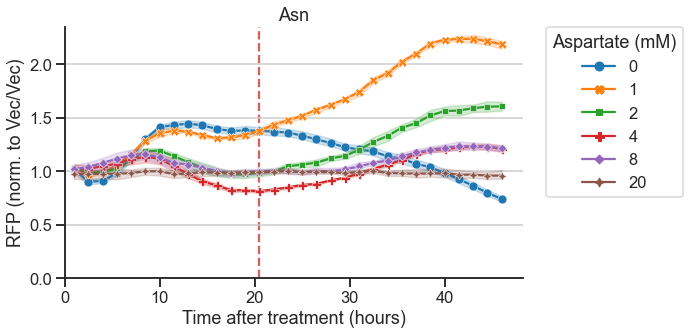

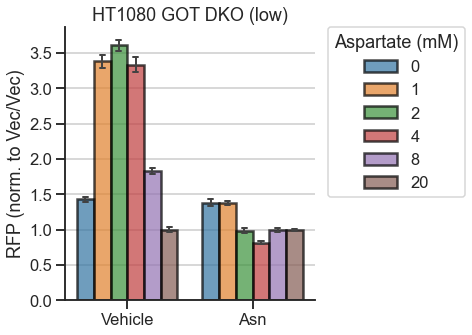

In [40]:
### Plot ###
folder = '02-01-22_high'

# Drug treatments:
drug_list = ['Vehicle', 'Rotenone', 'Antimycin']
red = {'NoMix': 20.5, 'Mix': 20.5}
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)

red = {'NoMix': 20.5, 'Mix': 20.5}
title = 'HT1080 GOT DKO (low)'
plot_bars(data, folder, red['NoMix'], norm, title, drug_incl=drug_list, fig_size_w=7.5)


# Aspartate gradient:
drug_list = ['Aspartate']
rescue_list = ['Vehicle', 'Asn']
red = {'NoMix': 20.5, 'Mix': 20.5}
norm = 'RFP_norm-Vec-Vec'
plot_timecourse_gradient(data, folder, drug_list, rescue_list, red, plot_dst, norm, fig_size_w=10)

red = {'NoMix': 20.5, 'Mix': 20.5}
title = 'HT1080 GOT DKO (low)'
plot_bars_gradient(data, folder, drug_list, red['NoMix'], norm, title, fig_size_w=7)

# Process 143B data from 02-02-22

In [41]:
### Process data ###
# These plates only have a single endpoint read #
cell_line_folder = '143B-WT_ATF4-rep'
date_list = ['02-02-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/143B/02-0X-22'

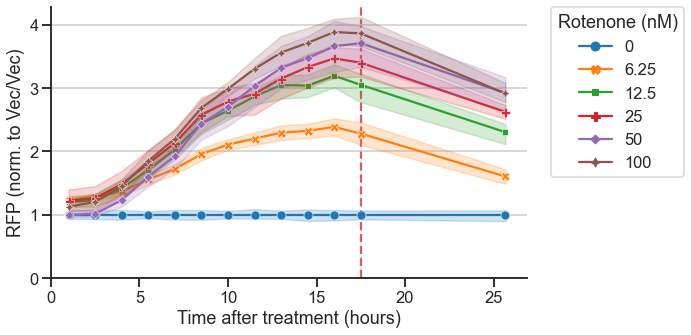

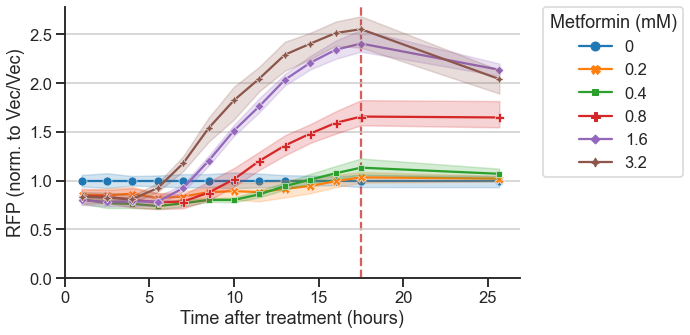

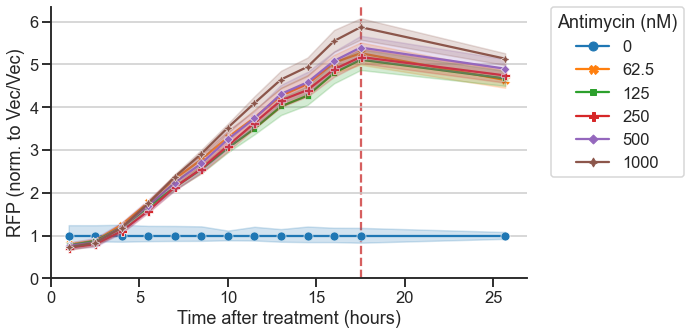

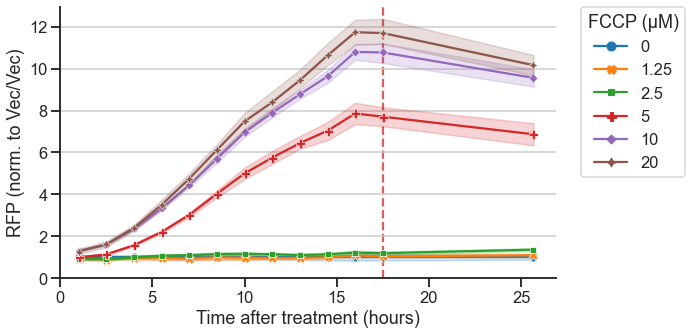

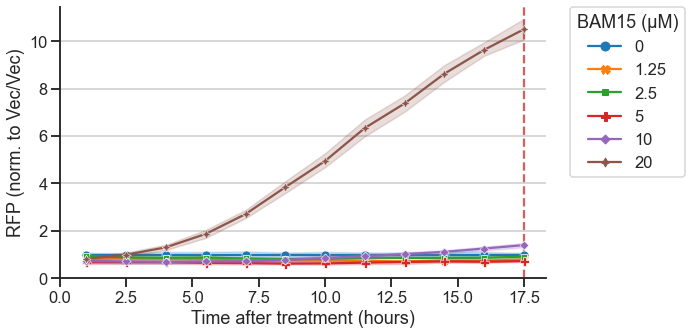

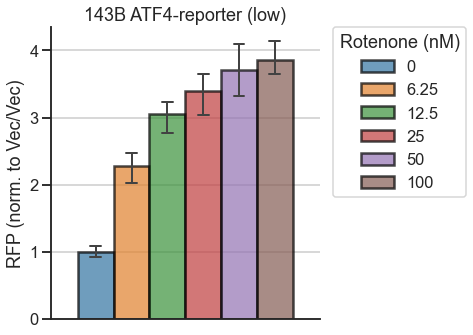

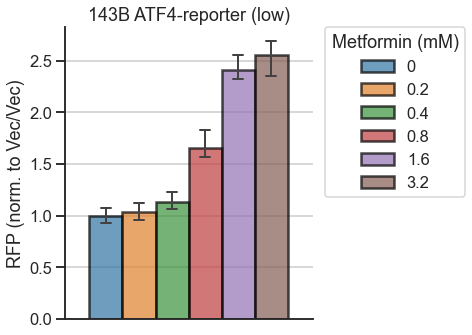

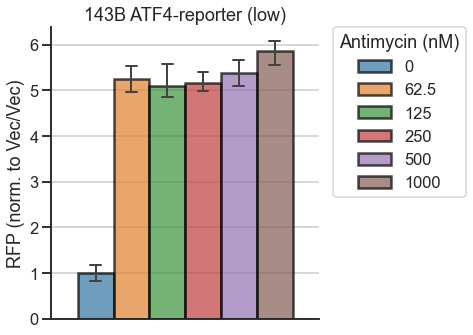

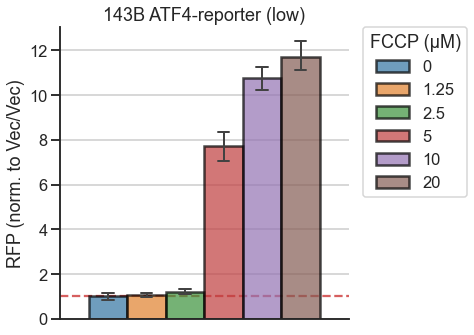

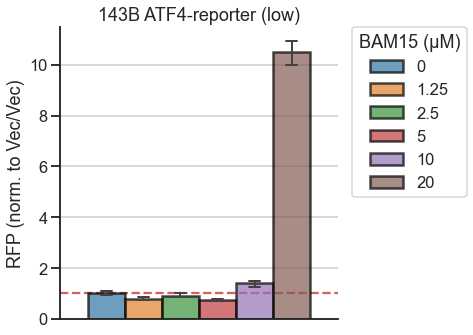

In [42]:
### Plot ###
folder = '02-02-22_low'
# Drug gradient:
drug_list = ['Rotenone', 'Metformin', 'Antimycin', 'FCCP', 'BAM15']
rescue_list = ['NA1']
red = {'NoMix': 17.5, 'Mix': 17.5}
norm = 'RFP_norm-Vec-Vec'
plot_timecourse_gradient(data, folder, drug_list, rescue_list, red, plot_dst, norm, \
                         fig_size_w=10, resc_excl=[])

title = '143B ATF4-reporter (low)'
plot_bars_gradient(data, folder, drug_list, red['NoMix'], norm, title, \
                   fig_size_w=7, resc_excl=[], show_xticks=False)

# Process 143B data from 02-03-22

In [43]:
### Process data ###
# These plates only have a single endpoint read #
cell_line_folder = '143B-WT_ATF4-rep'
date_list = ['02-03-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/143B/02-0X-22'

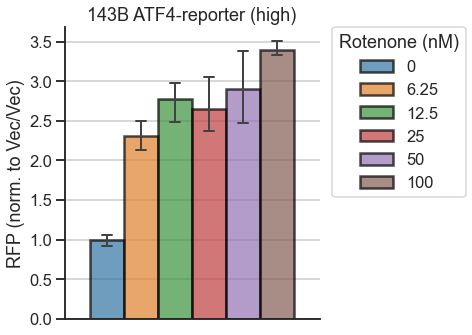

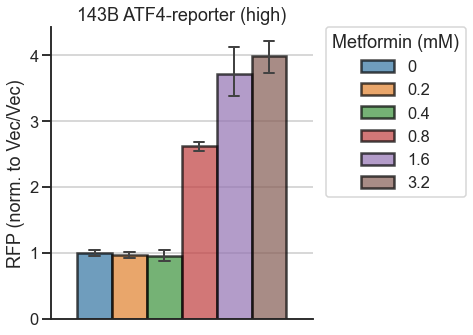

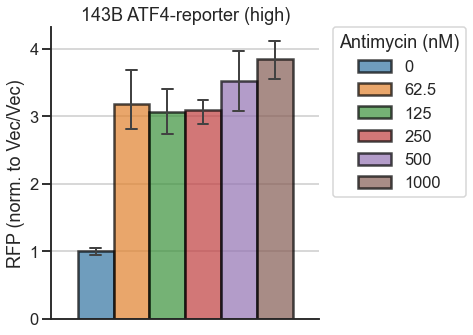

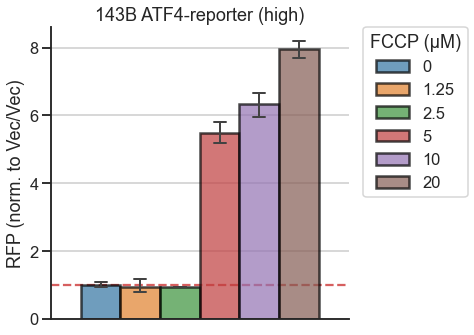

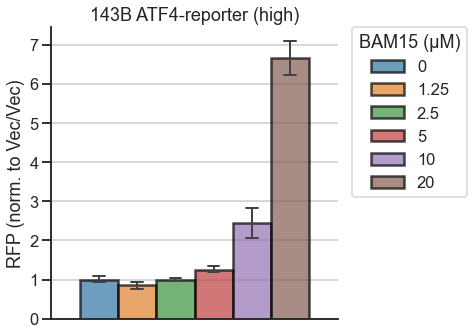

In [44]:
### Plot ###
folder = '02-03-22_high'
# Drug gradient:
drug_list = ['Rotenone', 'Metformin', 'Antimycin', 'FCCP', 'BAM15']
rescue_list = ['NA1']
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'

title = '143B ATF4-reporter (high)'
plot_bars_gradient(data, folder, drug_list, red['NoMix'], norm, title, \
                   fig_size_w=7, resc_excl=[], show_xticks=False)

# Process 143B data from 02-20-22

In [45]:
### Process data ###
cell_line_folder = '143B-WT_ATF4-rep'
date_list = ['02-20-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/143B/02-20-22'

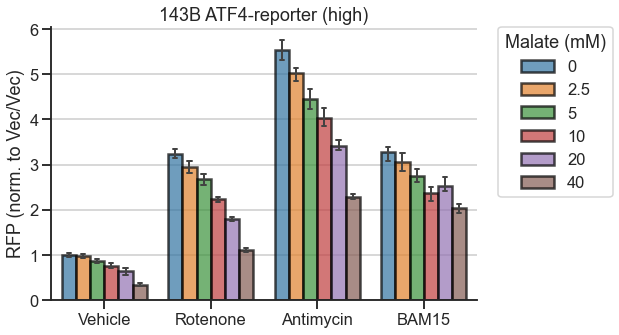

In [46]:
### Plot ###
folder = '02-20-22_high'

# Malate gradient:
drug_list = ['Malate']
rescue_list = ['Vehicle', 'Rotenone', 'Antimycin', 'BAM15']
red = {'NoMix': 17, 'Mix': 17}
norm = 'RFP_norm-Vec-Vec'
# plot_timecourse_gradient(data, folder, drug_list, rescue_list, red, plot_dst, norm, fig_size_w=10)
title = '143B ATF4-reporter (high)'
plot_bars_gradient(data, folder, drug_list, red['NoMix'], norm, title, fig_size_w=9)

# Process HT1080 data from 02-21-22

In [47]:
### Process data ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['02-21-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/HT1080/02-21-22'

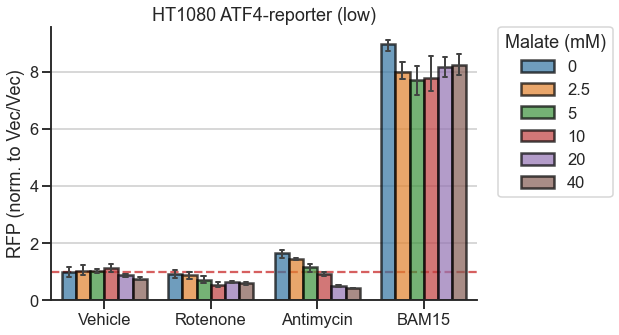

In [48]:
### Plot ###
folder = '02-21-22_low'

# Malate gradient:
### These cells were seeded in media with 20 mM Asp !!!!
drug_list = ['Malate']
rescue_list = ['Vehicle', 'Rotenone', 'Antimycin', 'BAM15']
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'
# plot_timecourse_gradient(data, folder, drug_list, rescue_list, red, plot_dst, norm, fig_size_w=10)
title = 'HT1080 ATF4-reporter (low)'
plot_bars_gradient(data, folder, drug_list, red['NoMix'], norm, title, fig_size_w=9)

# Process 143B data from 03-13-22

In [49]:
### Process data ###
cell_line_folder = '143B-WT_ATF4-rep'
date_list = ['03-13-22']
data = rp_data(cell_line_folder, date_list, sample_anno)
plot_dst = 'plots/143B/03-13-22'

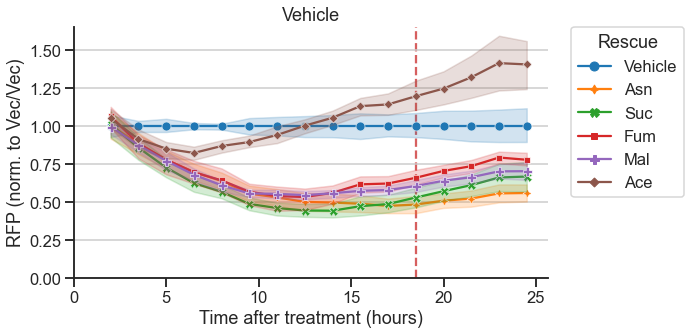

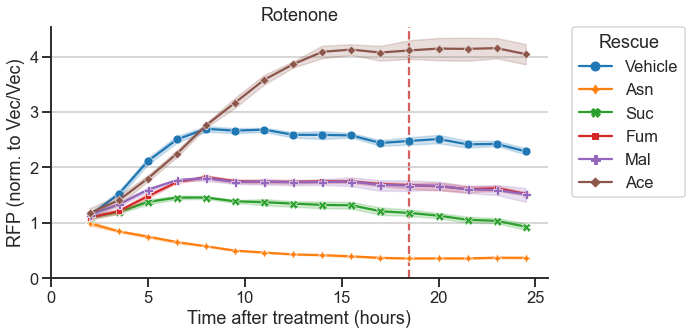

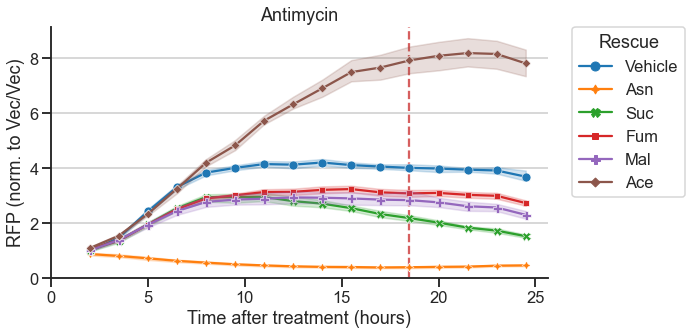

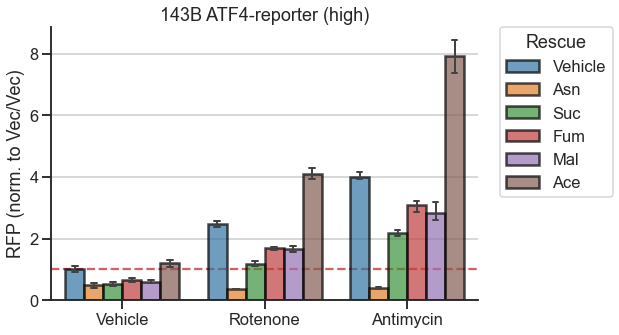

In [50]:
### Plot ###
folder = '03-13-22_high1'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin']
red = {'NoMix': 18.5, 'Mix': 18.5}
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)

title = '143B ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title, fig_size_w=9)